In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, OPTICS, Birch

In [2]:
df = pd.read_csv("sample_dataset.csv")

In [3]:
df.head()

,Location ID,Latitude,Longitude,Money Spent
0,1,35.838420,51.536620,144
1,26,35.837281,51.540437,112
2,51,35.899481,51.545548,126
3,76,35.831205,51.475443,79
4,101,35.887108,51.251004,147


## cluster based on 25 visitors
the number of points in each cluster should be approximately equal
the distance between the points in each cluster should be as small as possible
the distance between the clusters should be as large as possible
the total money spent by each cluster should be approximately equal

In [10]:
df = df.dropna()
model = AgglomerativeClustering(n_clusters=25, linkage="complete").fit(df.iloc[:, 1:3])

In [12]:
model.labels_

array([18, 18,  6,  9,  1, 23,  3, 15,  4,  8,  3,  3,  7, 16,  2,  8, 16,
        2, 19,  7,  8, 16,  1, 19,  4, 10, 12, 16,  0, 22,  5,  9,  7,  1,
       10, 13, 12, 16,  6, 16,  6,  2,  2, 12, 14, 17, 13,  0,  6,  7, 16,
       17,  6,  0,  0,  2, 22, 11,  5, 12,  9,  1,  1, 12,  4,  1, 20, 17,
        9,  3, 16,  8,  0,  5, 13,  7, 24, 23,  5,  1, 24, 19, 14, 17, 19,
        6, 20,  7,  3,  6,  9, 15,  0, 12, 11, 15,  8,  9, 19, 22, 18,  7,
       21, 16, 10, 16,  7,  3,  1,  2, 10, 18,  9, 15, 14, 16, 18, 11, 10,
        0,  7, 16, 20, 12, 15, 18, 23, 13,  4,  3, 21, 14, 19, 15,  2,  1,
        6, 19, 20, 12,  5, 20, 24,  4, 24,  2, 10,  8, 10, 17, 17,  4, 10,
        9,  2, 18, 20, 12, 15, 21, 12, 16, 22, 15,  1, 14, 16,  0, 24, 14,
        4,  6,  6, 14,  4, 15,  2, 21, 21, 24,  9, 11, 11, 15,  0, 13, 24,
        1, 12, 20, 20, 20,  9,  6, 18,  4,  4, 11,  5, 16,  8,  2, 16,  2,
       13, 19, 15,  5, 15, 22,  9,  9,  2, 12, 16, 17,  4, 21,  7, 18,  9,
        3,  2, 20,  1, 21

## plot the clusters

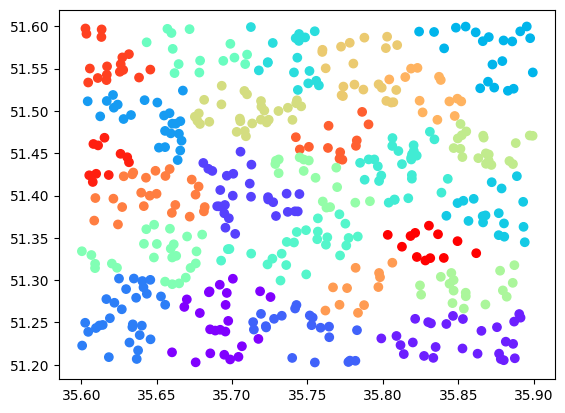

In [11]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 2], c=model.labels_, cmap="rainbow")